In [2]:
%pip install --upgrade keras keras_preprocessing

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
from math import floor

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# SVM
from sklearn.svm import LinearSVC  # for text, linear SVM usually works best
from sklearn.svm import SVC

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt_tab')
#nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

# LSTM (use "Base" conda env)
import tensorflow as tf
from keras.models import Sequential 
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
# from keras._tf_keras.keras.models import Sequential
# from keras._tf_keras.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#os.chdir(r"C:\Users\raned\Documents\GitHub\PostModeration")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/abigailcalderon/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/abigailcalderon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abigailcalderon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/abigailcalderon/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


This notebook will start off with preprocessing the two csv files to train different supervised learning models. 
- Removal of usernames, URLs, and special characters
- Lowercasing text
- Tokenization (nltk or spaCy): breaking text into smaller units 
- Stopword removal: remove common words that become index terms ("and", "or", "the", "in")
- Lemmatization: reduces words to their base or dictionary form
- TF-IDF vectorization for feature extraction: a technique that converts text data into numerical vectors, representing the importance of words in a document relative to a collection of documents, by combining term frequency with inverse document frequency

**count**: number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were

**hate_speech**: number of CF users who judged the tweet to be hate speech

**offensive_language**: number of CF users who judged the tweet to be offensive

**neither**: number of CF users who judged the tweet to be neither offensive nor non-offensive

**class**: class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither


---
---
---


## Start Here
The code below combines the two datasets into one dataframe before any thing gets preprocessed. Since SVMs and LSTMs require different formats for their text input data, I created new columns 'tokenized_clean_text' and 'cleaned_text' that contain different formats of text so that training_data_df['Content'] doesn't have to be re-preprocessed all over again wheneveer we switch between models. 

In [ ]:
# function to create a word cloud
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud

def create_wordcloud(df):
    # first check if df has both labels. if only one label, then create a word cloud for that label
    if df['Label'].nunique() != 2:
        # create a word cloud for the only label present
        text = " ".join(df['Content'])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        image = wordcloud.to_array()
        plt.figure(figsize=(10, 5))
        plt.imshow(image, interpolation='bilinear')
        plt.title('Word Cloud for Label {}'.format(df['Label'].unique()[0]))
        plt.axis('off')
        plt.show()
        return
        
    non_malicious_text = " ".join(df[df['Label'] == 0]['Content'])
    malicious_text = " ".join(df[df['Label'] == 1]['Content'])
    non_malicious_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap="Blues").generate(non_malicious_text)
    malicious_wordcloud = WordCloud(width=800, height=400, background_color='white',colormap="Reds").generate(malicious_text)
    non_malicious_image = non_malicious_wordcloud.to_array()
    malicious_image = malicious_wordcloud.to_array()
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(non_malicious_image, interpolation='bilinear')
    plt.title('Non Malicious Tweets')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(malicious_image, interpolation='bilinear')
    plt.title('Malicious Tweets')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


#visualize word count
def visualize_word_count(df):
    # Create a new column for word count
    temp_df = df.copy()
    temp_df['Word Count'] = temp_df['Content'].apply(lambda x: len(str(x).split()))
    
    # Plot the distribution of word counts
    plt.figure(figsize=(10, 5))
    sns.histplot(temp_df['Word Count'], bins=30, kde=True)
    plt.title('Distribution of Word Counts')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.show()




In [370]:
emotions_df = pd.read_csv("TrainingData/text.csv")
emotions_df['Content'] = emotions_df['text']
emotions_df['Label'] = emotions_df['label']
emotions_df.drop(columns=['Unnamed: 0','text','label'],inplace=True)
emotions_df['Label']= emotions_df['Label'].replace(to_replace=[0,1,2,3,4,5], value = [0,0,0,0,0,0])
emotions_df['Source'] = 'text.csv (emotion data)'
# print("emotions: ",emotions_df['Label'].value_counts())

crowd_df = pd.read_csv("TrainingData/labeled_data.csv") 
crowd_df['Content'] = crowd_df['tweet']
hatespeech = crowd_df[crowd_df['class']==0].sample(n=1430, random_state=42).copy() # hate speech
nonHateful = crowd_df[crowd_df['class']==2].sample(n=2730, random_state=42).copy() # not hate speech
offensive = crowd_df[crowd_df['class']==1].sample(n=430, random_state=42).copy() # offensive
crowd_df = pd.concat([hatespeech, nonHateful, offensive], ignore_index=True)
crowd_df['Label'] = crowd_df['class'].replace(to_replace=[0,1,2], value = [1,0,0])  # 0=clean, 1=hate speech,
crowd_df['Source'] = 'labeled_data.csv'
crowd_df = crowd_df[['Content','Label','Source']].copy()
# print("crowd_df: ",crowd_df['Label'].value_counts())

balanced_df = pd.read_csv("TrainingData/combined_df_2.csv")
balanced_df['Source'] = 'HateSpeechDatasetBalanced.csv'
# print("balanced_df: ", balanced_df.shape)
# print(balanced_df['Label'].value_counts())


cyberbullying_df = pd.read_csv("TrainingData/CyberBullyingCommentsDataset2.csv")
cyberbullying_df['Content'] = cyberbullying_df['Text'].str.replace(r'\\xa0', ' ', regex=True) #remove "\xa0+" from text
cyberbullying_df['Label'] = cyberbullying_df['CB_Label']
cyberbullying_df = cyberbullying_df[['Content','Label']]
cyberbullying_df['Source'] = 'CyberBullyingCommentsDataset2.csv'
# print("cyberbullying_df: ",cyberbullying_df['Label'].value_counts())

# easier way to keep track of how much of each label is available for each source
label_counts = []
def get_label_counts(df_name,df):
    # check if df has both labels. if only one label, then return the counts for that label
    if df['Label'].nunique() != 2:
        # create a list with the name of the df and the count of the only label present
        x = [df_name, df['Label'].value_counts()[0], 0]
        label_counts.append(x)
        return
    x = [df_name,df['Label'].value_counts()[0], df['Label'].value_counts()[1]]
    label_counts.append(x)

get_label_counts("emotion",emotions_df), get_label_counts("hateSpeechBalanced",balanced_df), get_label_counts("crowdsourced",crowd_df), get_label_counts("cyberbullying",cyberbullying_df)
print("Label counts                 0           1 ")
print("-------------------------------------------------")
for df in label_counts:
    # ensure the spaces are aligned
    if len(df[0]) < 20:
        source = df[0] + ' ' * (20 - len(df[0]))
    elif len(df[0]) > 20:
        source = df[0][:20]
    print(source,"     ",df[1],"      ",df[2])

Label counts                 0           1 
-------------------------------------------------
emotion                    416809        0
hateSpeechBalanced         4320        16000
crowdsourced               3160        1430
cyberbullying              5550        5550


In [363]:
for source in label_counts:
    print(source[0])

emotion
hateSpeechBalanced
crowdsourced
cyberbullying


In [386]:

# total samples per label
TOTAL_HATE = 15050
TOTAL_NON_HATE = 15050


note = "want to include more nonhate from cyberbullying "

# percentages must add to 1.0 for each label
HATE_PERCENTS = {
    'hateSpeechBalanced': 0.88,    # 70% of TOTAL_HATE from HateSpeechBalanced
    'crowdsourced': 0.08, # 30% of TOTAL_HATE from crowdsourced (labeled_data)
    'cyberbullying' : 0.04, # 0% of TOTAL_HATE from cyberbullying (not used in this example)
}

NON_HATE_PERCENTS = {
    'emotion': 0.20,       # 40% of TOTAL_NON_HATE from emotion data
    'hateSpeechBalanced': 0.25,     # 40% of TOTAL_NON_HATE from HateSpeechBalanced
    'crowdsourced': 0.20, # 20% of TOTAL_NON_HATE from labeled_data
    'cyberbullying' : 0.35
}


hate_counts = {
    'hateSpeechBalanced': floor(TOTAL_HATE * HATE_PERCENTS['hateSpeechBalanced']),
    'crowdsourced': floor(TOTAL_HATE * HATE_PERCENTS['crowdsourced']),
    'cyberbullying': floor(TOTAL_HATE * HATE_PERCENTS['cyberbullying']),
}

non_hate_counts = {
    'emotion': floor(TOTAL_NON_HATE * NON_HATE_PERCENTS['emotion']),
    'hateSpeechBalanced': floor(TOTAL_NON_HATE * NON_HATE_PERCENTS['hateSpeechBalanced']),
    'crowdsourced': floor(TOTAL_NON_HATE * NON_HATE_PERCENTS['crowdsourced']),
    'cyberbullying': floor(TOTAL_NON_HATE * NON_HATE_PERCENTS['cyberbullying']),
    
    
}



# sanity check
# print("TOTAL hate:", sum(hate_counts.values()), "Expected:", TOTAL_HATE)
# print("TOTAL non-hate:", sum(non_hate_counts.values()), "Expected:", TOTAL_NON_HATE)
# print("Hate counts:", hate_counts)
# print("Non-hate counts:", non_hate_counts)


available = {
    'hate': {
        'hateSpeechBalanced': balanced_df[balanced_df['Label'] == 1].shape[0],
        'crowdsourced': crowd_df[crowd_df['Label'] == 1].shape[0],
        'cyberbullying': cyberbullying_df[cyberbullying_df['Label'] == 1].shape[0],
    },
    'non_hate': {
        'hateSpeechBalanced': balanced_df[balanced_df['Label'] == 0].shape[0],
        'crowdsourced': crowd_df[crowd_df['Label'] == 0].shape[0],
        'cyberbullying': cyberbullying_df[cyberbullying_df['Label'] == 0].shape[0],
        'emotion': emotions_df.shape[0],
       
    }
}

# calculate raw counts from desired percentages
desired_hate = {k: int(TOTAL_HATE * v) for k, v in HATE_PERCENTS.items()}
desired_non_hate = {k: int(TOTAL_NON_HATE * v) for k, v in NON_HATE_PERCENTS.items()}

for source in label_counts:
    key = source[0]
    print(key)
    if key in available['hate']:
        difference = available['hate'][key] - desired_hate[key]
        if difference < 0:
            print("     HATE  -  Desired: ", desired_hate[key], " Actual: ", available['hate'][key], " Short: ", difference)
        else:
            print("     HATE  -  Desired: ", desired_hate[key], " Actual: ", available['hate'][key])
    if key in available['non_hate']:
        difference = available['non_hate'][key] - desired_non_hate[key]
        if difference < 0:
            print("     NONHATE  -  Desired: ", desired_non_hate[key], " Actual: ", available['non_hate'][key], " Short: ", difference)
        else:
            print("     NONHATE - Desired: ", desired_non_hate[key], " Actual: ", available['non_hate'][key])




# for hate,nonhate in zip(available['hate'].keys(),available['non_hate'].keys()):
#     print(hate)
#     difference = available['hate'][hate]-desired_hate[hate]
#     if difference < 0: #not enough available data to meet percentage distribution 
#         print("     HATE  -  Desired: ",desired_hate[hate], " Actual: ",available['hate'][hate], " Short: ", difference)
#     else:
#         print("     HATE  -  Desired: ",desired_hate[hate], " Actual: ",available['hate'][hate])
#     if hate != nonhate:
#         print(nonhate)
#     difference = available['non_hate'][nonhate]-desired_non_hate[nonhate]
#     if difference < 0: #not enough available data to meet percentage distribution 
#         print("     NONHATE  -  Desired: ",desired_non_hate[nonhate], " Actual: ",available['non_hate'][nonhate], " Short: ", difference)
#     else:
#         print("     NONHATE - Desired: ",desired_non_hate[nonhate], " Actual: ",available['non_hate'][nonhate])




# determine scale factor (max 1.0) for each label 
# hate_scale = min(1.0, min([available['hate'][k] / desired_hate[k] for k in desired_hate]))
# non_hate_scale = min(1.0, min([available['non_hate'][k] / desired_non_hate[k] for k in desired_non_hate]))
hate_scale = 1.0
non_hate_scale = 1.0

# apply scaling
actual_hate = {k: int(desired_hate[k] * hate_scale) for k in desired_hate}
# print("Actual hate counts after scaling:", actual_hate)
actual_non_hate = {k: int(desired_non_hate[k] * non_hate_scale) for k in desired_non_hate}

print("\nFinal sample sizes:")
print("  Hate Speech:", actual_hate)
print("  Non-Hate Speech:", actual_non_hate)
print("  Total Hate:", sum(actual_hate.values()))
print("  Total Non-Hate:", sum(actual_non_hate.values()))



emotion
     NONHATE - Desired:  3010  Actual:  416809
hateSpeechBalanced
     HATE  -  Desired:  13244  Actual:  13244
     NONHATE - Desired:  3762  Actual:  3762
crowdsourced
     HATE  -  Desired:  1204  Actual:  1204
     NONHATE - Desired:  3010  Actual:  3010
cyberbullying
     HATE  -  Desired:  602  Actual:  602
     NONHATE - Desired:  5267  Actual:  5267

Final sample sizes:
  Hate Speech: {'hateSpeechBalanced': 13244, 'crowdsourced': 1204, 'cyberbullying': 602}
  Non-Hate Speech: {'emotion': 3010, 'hateSpeechBalanced': 3762, 'crowdsourced': 3010, 'cyberbullying': 5267}
  Total Hate: 15050
  Total Non-Hate: 15049


Since all this data is to train the model on what "clean" tweets should look like, we should be careful with the model possibly learning that clean tweets tend to start with "I" or must include the word "feel/feeling"

In [ ]:
emotions_df
crowd_df
cyberbullying_df
training_data_df

Label
0    3009
Name: count, dtype: int64


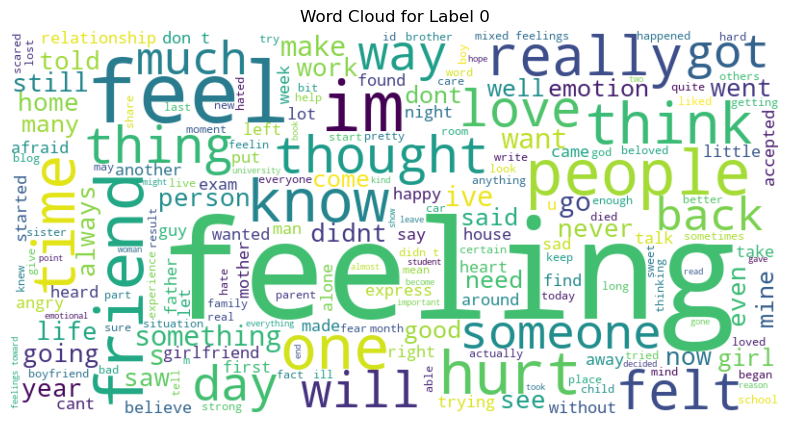

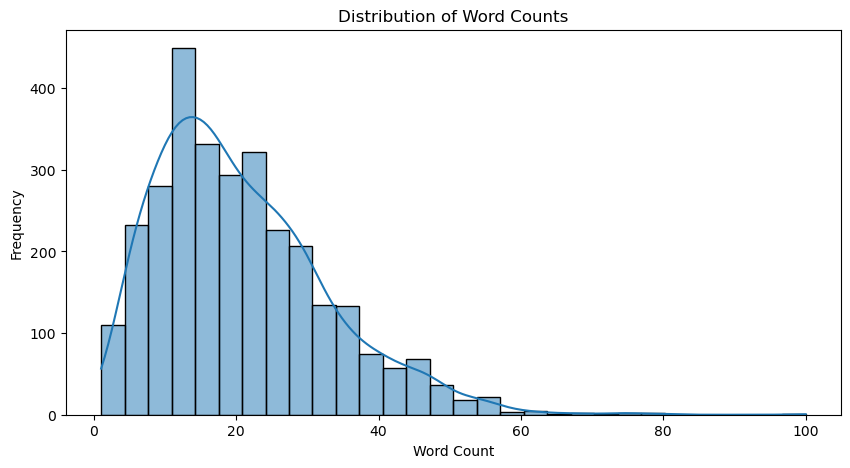

crowd_df shape after sampling:  (4214, 3)


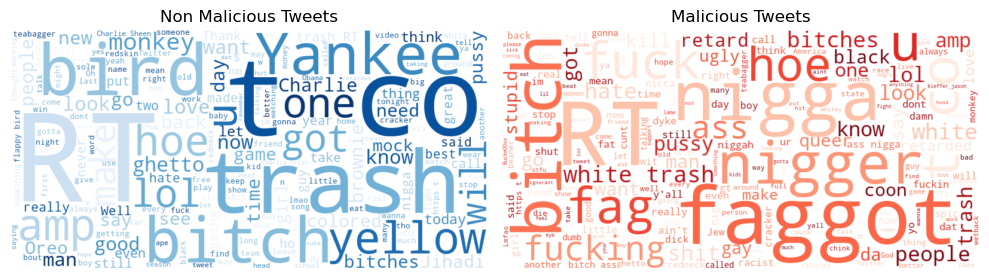

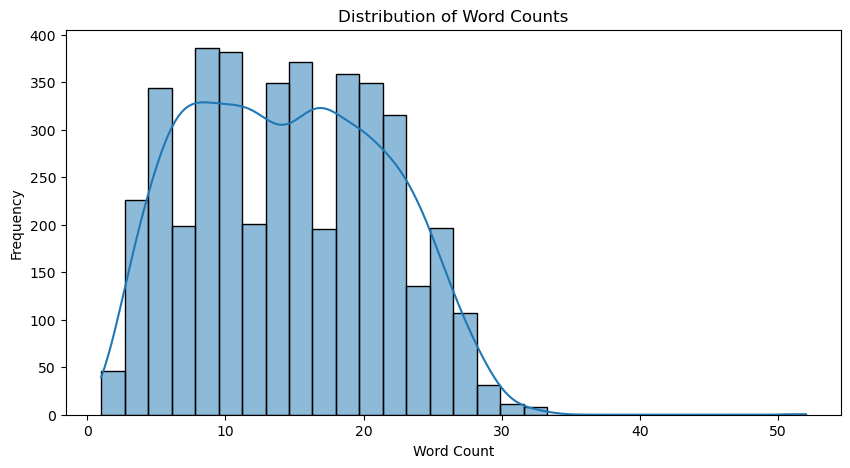

balanced_df shape after sampling:  (17006, 6)


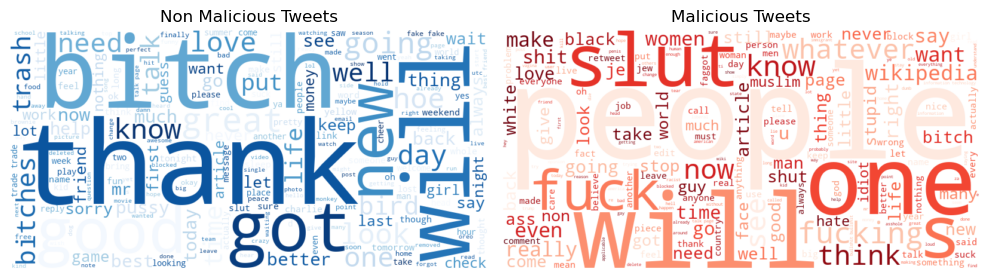

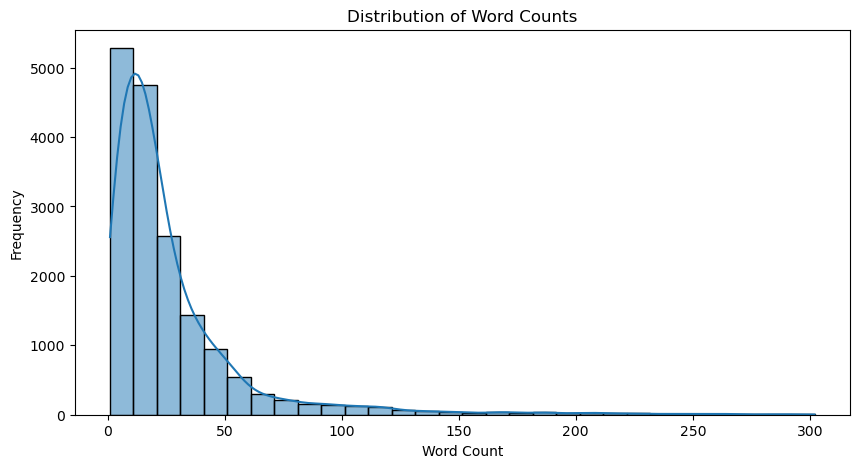

cyberbullying_df shape after sampling:  (5869, 3)


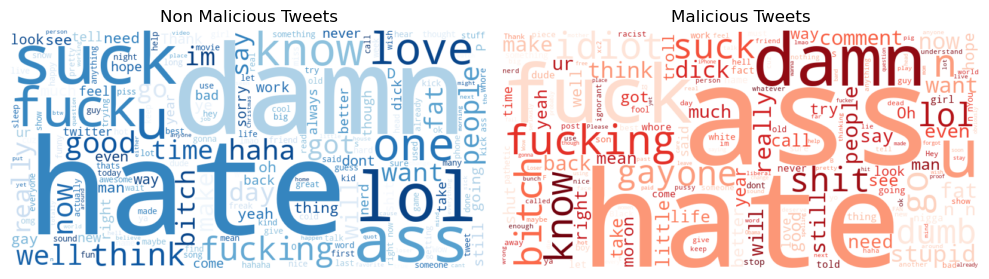

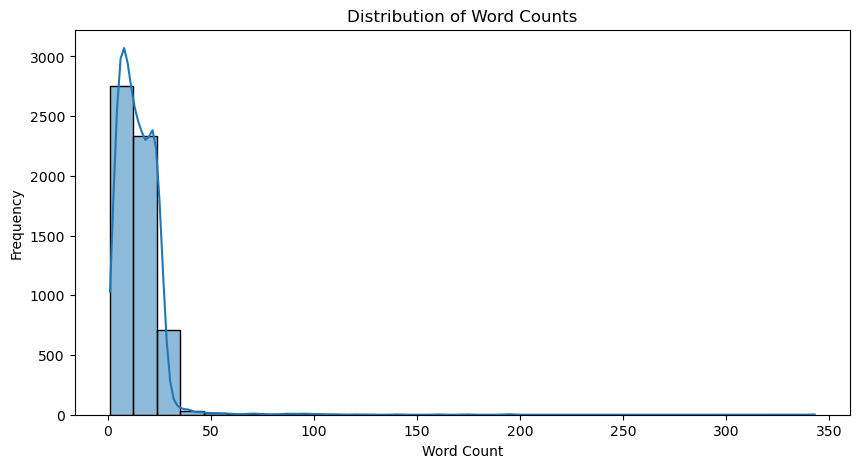

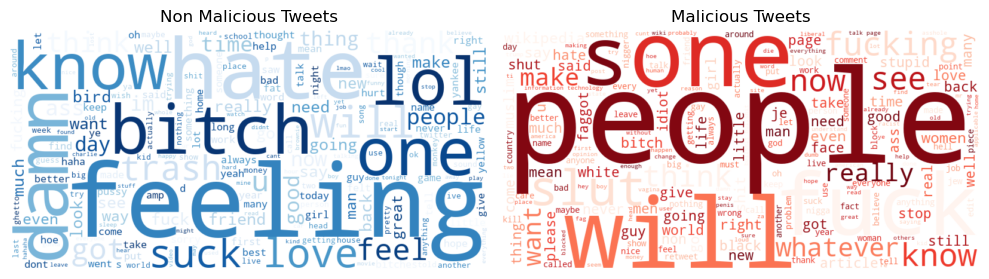

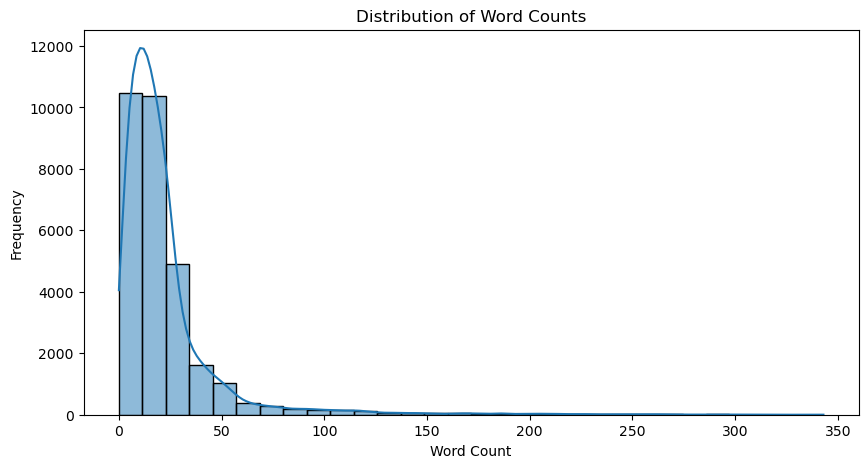

Label
1    15050
0    15048
Name: count, dtype: int64


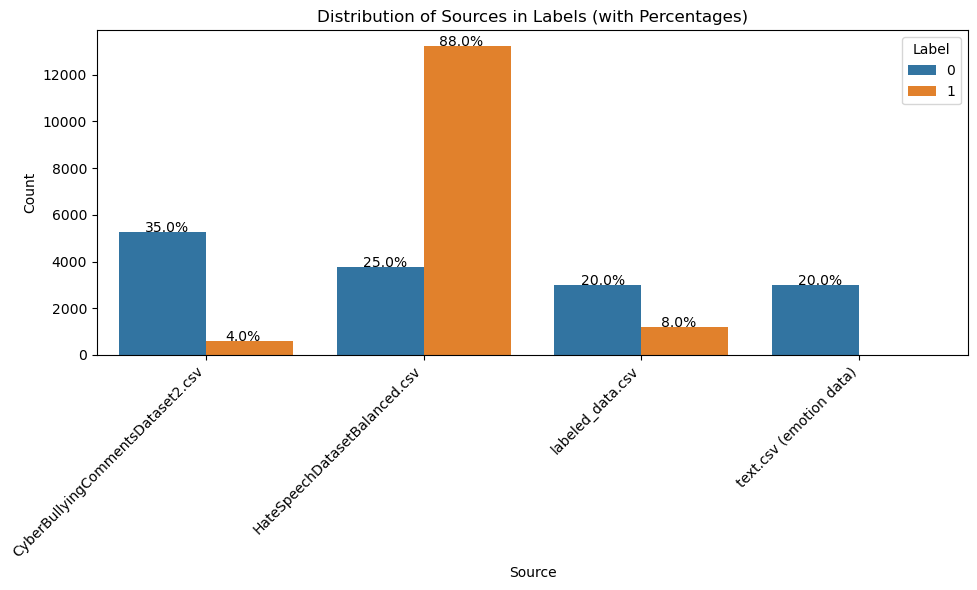

<Figure size 640x480 with 0 Axes>

In [387]:

# ================== Dataset: emotion =======================
# most of the rows contain the word "feeling/feels/feel" which might skew the data, the code below will ensure the data is balanced in that respect
emotion_data_size = actual_non_hate['emotion']  # this is the size of the emotion data we want to use
no_feeling_df = emotions_df[~emotions_df['Content'].str.contains(r'\bfeel(?:s|ing)?\b', case=False, regex=True)].sample(n=int(emotion_data_size * 0.85), random_state=42).copy()
feeling_df = emotions_df[emotions_df['Content'].str.contains(r'\bfeel(?:s|ing)?\b', case=False, regex=True)].sample(n=int(emotion_data_size * 0.15), random_state=42).copy()

# print("emotion_data_size: ", emotion_data_size)
# print("no_feeling_size: ", no_feeling_df.shape[0])

emotions = pd.concat([feeling_df,no_feeling_df],ignore_index=True)
print(emotions['Label'].value_counts())
create_wordcloud(emotions)
visualize_word_count(emotions)


# #============================================ labeled_data.csv ============================================
temp_hate_df = crowd_df[crowd_df['Label'] == 1].sample(n=actual_hate['crowdsourced'], random_state=42).copy()
temp_non_hate_df = crowd_df[crowd_df['Label'] == 0].sample(n=actual_non_hate['crowdsourced'], random_state=42).copy()
crowd_df = pd.concat([temp_hate_df, temp_non_hate_df], ignore_index=True)
print("crowd_df shape after sampling: ", crowd_df.shape)

create_wordcloud(crowd_df)
visualize_word_count(crowd_df)

# #============================================ HateSpeechDatasetBalanced.csv ============================================
temp_hate_df = balanced_df[balanced_df['Label'] == 1].sample(n=actual_hate['hateSpeechBalanced'], random_state=42).copy()
temp_non_hate_df = balanced_df[balanced_df['Label'] == 0].sample(n=actual_non_hate['hateSpeechBalanced'], random_state=42).copy()
balanced_df = pd.concat([temp_hate_df, temp_non_hate_df], ignore_index=True)
print("balanced_df shape after sampling: ", balanced_df.shape)

create_wordcloud(balanced_df)
visualize_word_count(balanced_df)

# #============================================ CyberBullyingCommentsDataset2.csv ============================================
temp_hate_df = cyberbullying_df[cyberbullying_df['Label'] == 1].sample(n=actual_hate['cyberbullying'], random_state=42).copy()
temp_non_hate_df = cyberbullying_df[cyberbullying_df['Label'] == 0].sample(n=actual_non_hate['cyberbullying'], random_state=42).copy()
cyberbullying_df = pd.concat([temp_hate_df, temp_non_hate_df], ignore_index=True)

print("cyberbullying_df shape after sampling: ", cyberbullying_df.shape)
create_wordcloud(cyberbullying_df)
visualize_word_count(cyberbullying_df)

training_data_df = pd.concat([emotions, crowd_df, balanced_df, cyberbullying_df], ignore_index=True)
training_data_df = training_data_df[['Content', 'Label', 'Source']].copy()
# clean training data
training_data_df['Content']= training_data_df['Content'].astype(str).str.casefold()
clean_content = training_data_df['Content'].str.replace(r'(rt)?\s?@\w+:?', ' ', regex=True).str.replace(r'http.+', ' ', regex=True)
training_data_df['Content'] = clean_content

# to csv
training_data_df.to_csv("TrainingData/combined_training_data.csv", index=False)

create_wordcloud(training_data_df)
visualize_word_count(training_data_df)

# check if the data is balanced 
print(training_data_df['Label'].value_counts())


counts = training_data_df.groupby(['Source', 'Label']).size().reset_index(name='Count')
counts['PercentWithinLabel'] = counts.groupby('Label')['Count'].transform(lambda x: (x / x.sum()) * 100)

# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=counts, x='Source', y='Count', hue='Label')
# plt.title('Distribution of Sources in Labels (with Percentages)')
# plt.xticks(rotation=45, ha='right')
# plt.xlabel('Source')
# plt.ylabel('Count')

# # annotate with percentage
# for i in range(len(counts)):
#     row = counts.iloc[i]
#     ax.text(
#         x=i//2 + (0.17 if row['Label'] == 1 else -0.178),  # slight offset
#         y=row['Count'] + 2,
#         s=f"{row['PercentWithinLabel']:.1f}%",
#         ha='center'
#     )

# plt.legend(title='Label', loc='upper right')
# plt.tight_layout()


# save image and include datetime in filename
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
plt.figure(figsize=(10, 6))
sns.barplot(data=counts, x='Source', y='Count', hue='Label')
plt.title('Distribution of Sources in Labels (with Percentages)')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Source')
plt.ylabel('Count')
for i in range(len(counts)):
    row = counts.iloc[i]
    plt.text(
        x=i//2 + (0.17 if row['Label'] == 1 else -0.178),  # slight offset
        y=row['Count'] + 2,
        s=f"{row['PercentWithinLabel']:.1f}%",
        ha='center'
    )
plt.legend(title='Label', loc='upper right')
plt.tight_layout()
plt.show()
plt.savefig(f"plots/Source_Distribution_{now}.png", bbox_inches='tight', dpi=300)




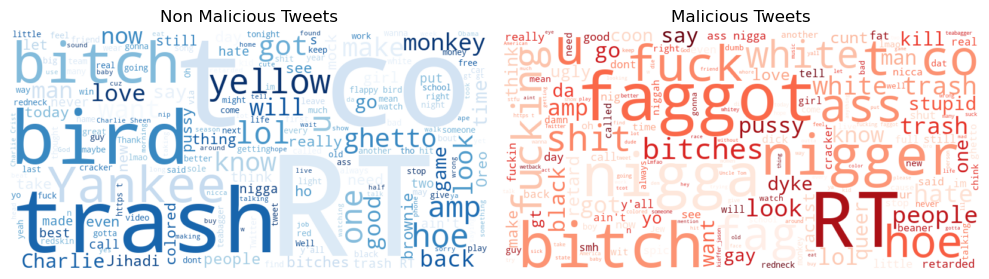

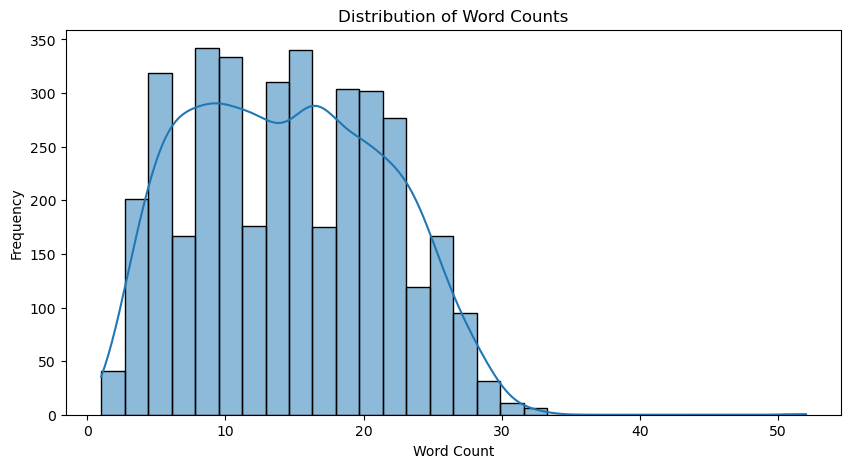

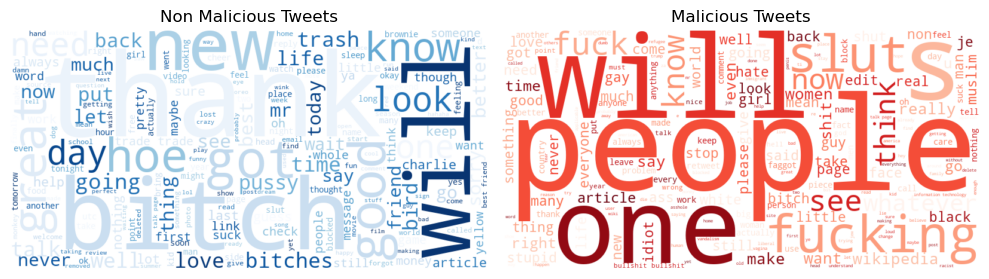

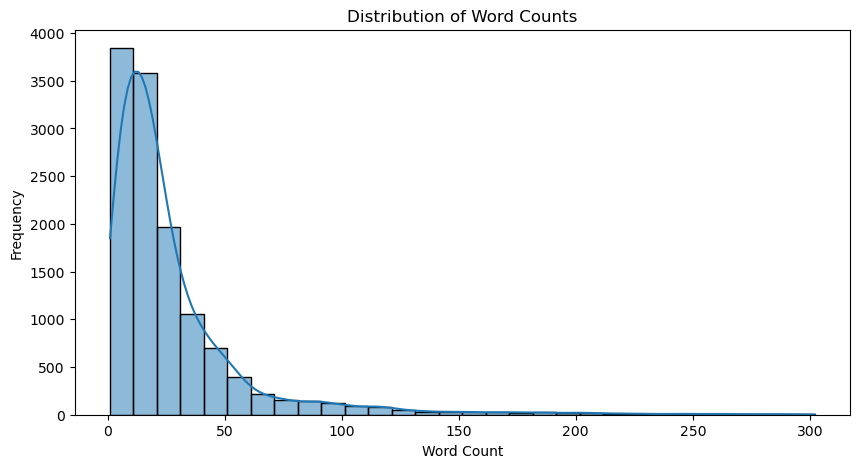

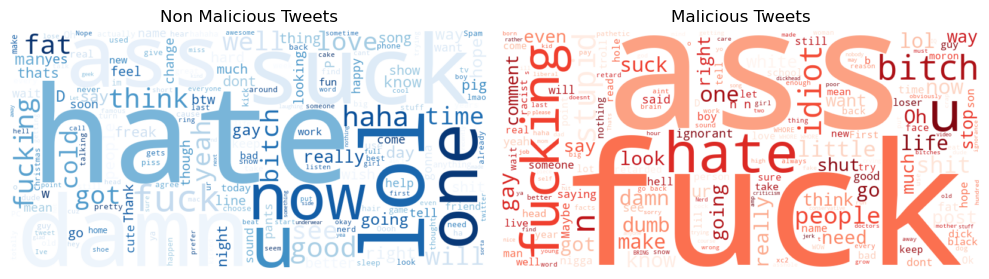

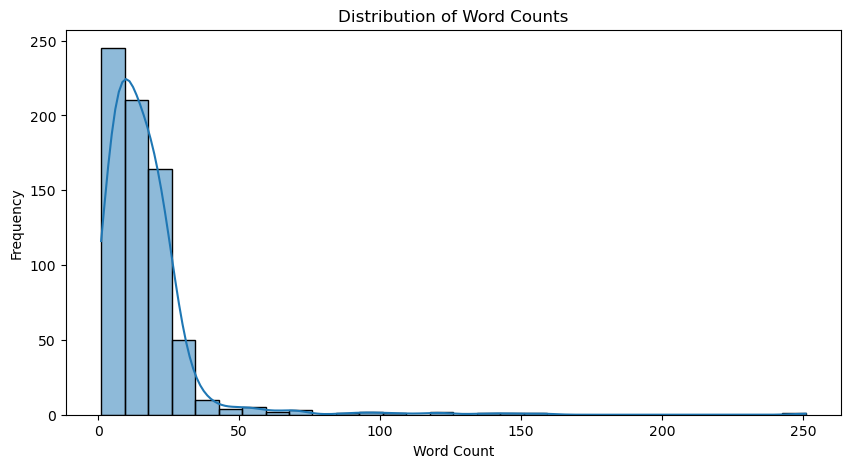

In [ ]:

# since both datasets have "Content/Tweet" and "Label/class" columns, the following code will merge the two datasets into one dataframe while maintaining balance





# visualize_word_count(sampled_hatespeech_df)
# df1 = pd.read_csv("TrainingData/labeled_data.csv")
# #reduced_df1['class'].value_counts()    #1430 tweets marked at hate-speech, so we will extract 1430 marked for hate speech and 1430 that aren't

# # get rid of all the extra columns that aren't relevant
# reduced_df1 = df1[['tweet','class']]

# # extracts 1430 marked for hate speech and 1430 that aren't and combine into one df
# hatespeech = reduced_df1[reduced_df1['class']==0].sample(n=1430, random_state=42).copy() # hate speech
# nonHateful = reduced_df1[reduced_df1['class']==2].sample(n=2730, random_state=42).copy() # not hate speech
# offensive = reduced_df1[reduced_df1['class']==1].sample(n=430, random_state=42).copy() # offensive
# sampled_hatespeech_df = pd.concat([hatespeech,nonHateful,offensive], ignore_index=True)


# # edit the values in 'Class' so that they match the values for HateSpeechDatasetBalanced.csv 
# # Clean: 0, Hate speech: 1
# sampled_hatespeech_df['Content'] = sampled_hatespeech_df['tweet']
# sampled_hatespeech_df['Label'] = sampled_hatespeech_df['class'].replace(to_replace=[0,1,2], value = [1,0,0])
# sampled_hatespeech_df['Source'] = 'labeled_data.csv'
# sampled_hatespeech_df = sampled_hatespeech_df.drop(columns=['tweet','class'])



# create_wordcloud(sampled_hatespeech_df)
# visualize_word_count(sampled_hatespeech_df)





(20000, 5)
(20000, 3)


/var/folders/nh/b84nc6pd1353r3vmzmt9rxw80000gn/T/ipykernel_42507/1837236466.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['Source'] = 'HateSpeechDatasetBalanced.csv'


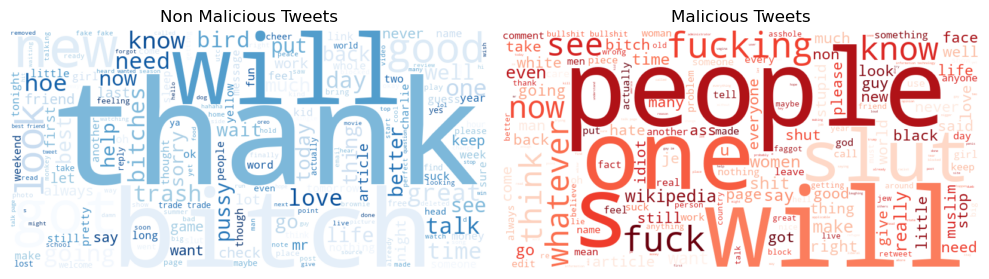

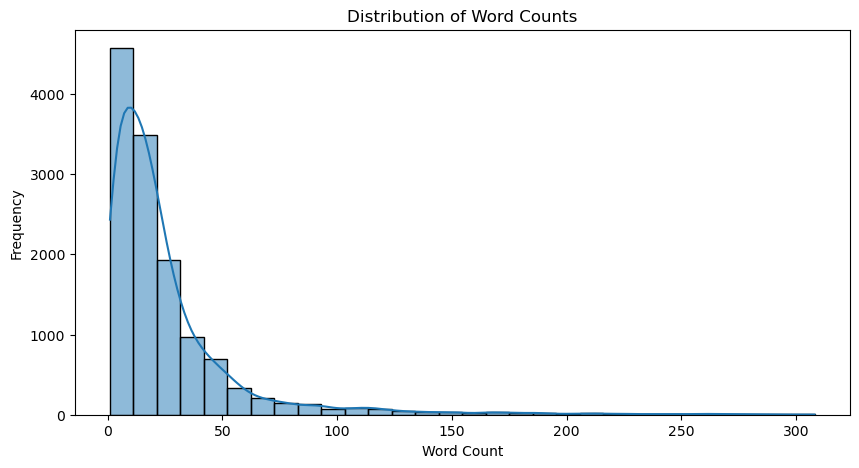

In [ ]:

#============================================ HateSpeechDatasetBalanced.csv ============================================
# df = pd.read_csv("TrainingData/HateSpeechDatasetBalanced.csv")
df = pd.read_csv("TrainingData/combined_df_2.csv")

df_subset = df.sample(n=20000, random_state=42).copy()
print(df_subset.shape)

temp_df = df_subset[['Content','Label']]
temp_df['Source'] = 'HateSpeechDatasetBalanced.csv'
print(temp_df.shape)

hatespeech = temp_df[temp_df['Label']==1].sample(n=9000, random_state=42).copy() # hate speech
nonHateful = temp_df[temp_df['Label']==0].sample(n=hateSpeechBalanced_size, random_state=42).copy() # nonhate speech


# combine both datasets into one:
trainingTemp_data_df = pd.concat([hatespeech,nonHateful],ignore_index=True)
trainingTemp_data_df['Source'] = 'HateSpeechDatasetBalanced.csv'

create_wordcloud(trainingTemp_data_df)
visualize_word_count(trainingTemp_data_df)


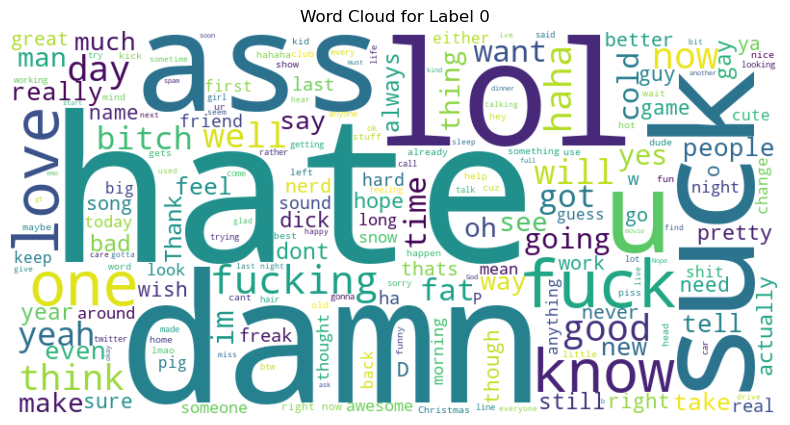

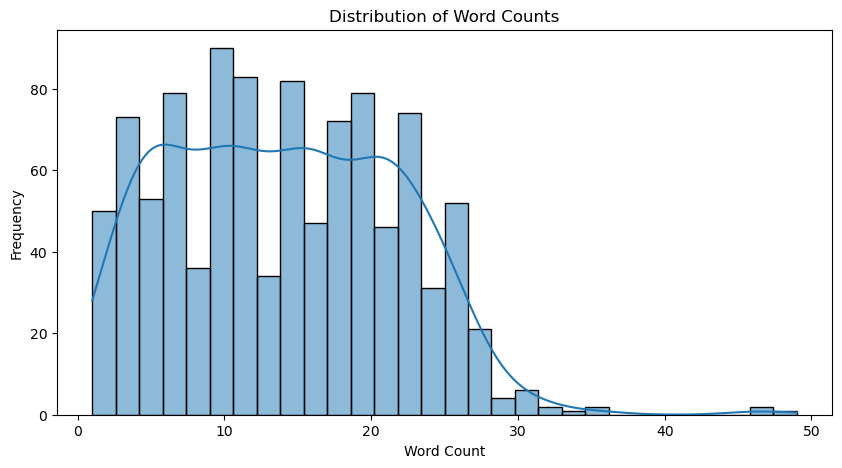

Label
0    1020
Name: count, dtype: int64


In [ ]:
# cyberbullying data
df_cyberbullying = pd.read_csv("TrainingData/CyberBullyingCommentsDataset2.csv").sample(n=2000, random_state=42).copy()
df_cyberbullying['Content'] = df_cyberbullying['Text']

#remove "\xa0+" from text
df_cyberbullying['Content'] = df_cyberbullying['Content'].str.replace(r'\\xa0', ' ', regex=True)
df_cyberbullying['Label'] = df_cyberbullying['CB_Label']

# drop the extra columns
df_cyberbullying = df_cyberbullying[['Content','Label']]
df_cyberbullying['Source'] = 'CyberBullyingCommentsDataset2.csv'

df_cyberbullying = df_cyberbullying[df_cyberbullying['Label'] == 0]

create_wordcloud(df_cyberbullying)
visualize_word_count(df_cyberbullying)

print(df_cyberbullying['Label'].value_counts())

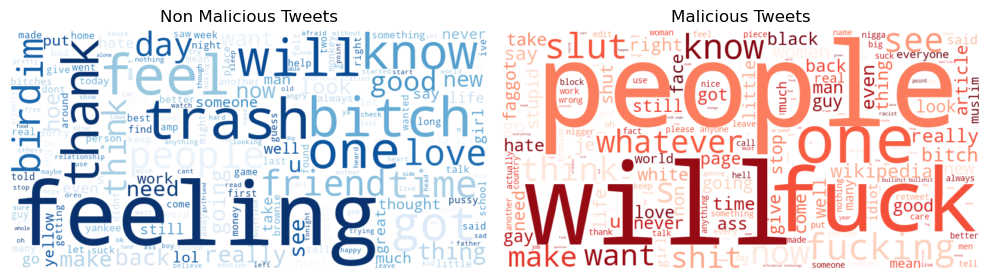

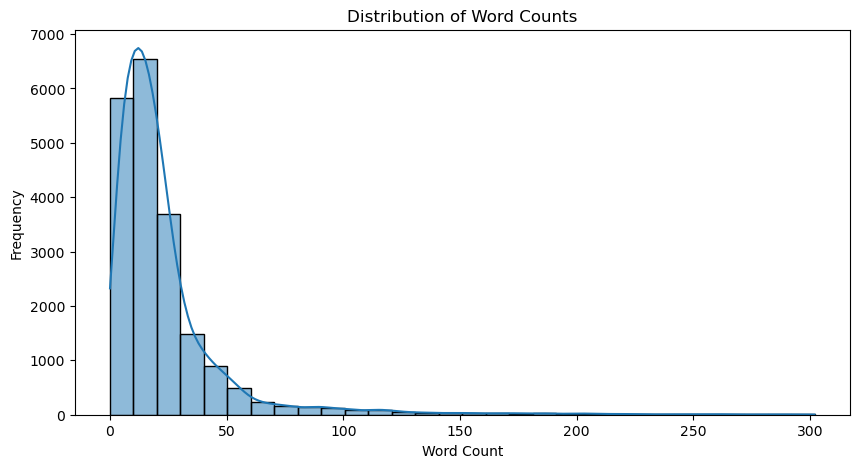

Label
1    11521
0     8577
Name: count, dtype: int64
                                             Content  Label  \
0  i feel that being loyal to your friends is one...      0   
1  i just feel i could explore the poses even mor...      0   
2  i challenge you to look at these each time you...      0   
3  i was originally feeling generous my pal david...      0   
4  im he and my mom and i will encounter a few mo...      0   

                    Source cleaned  pred_prob  predicted_label  
0  text.csv (emotion data)     NaN        NaN              NaN  
1  text.csv (emotion data)     NaN        NaN              NaN  
2  text.csv (emotion data)     NaN        NaN              NaN  
3  text.csv (emotion data)     NaN        NaN              NaN  
4  text.csv (emotion data)     NaN        NaN              NaN  


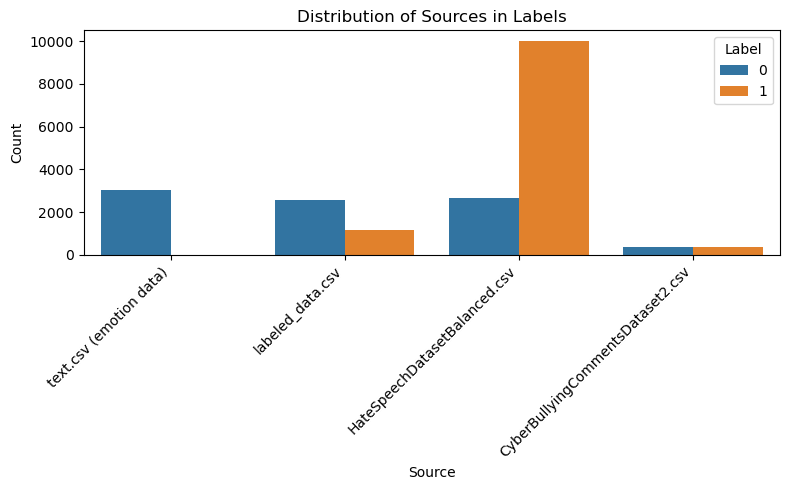

In [234]:
# combine all datasets into one
#training_data_df  = pd.concat([sampled_hatespeech_df,emotions,trainingTemp_data_df],ignore_index=True)
# training_data_df  = pd.concat([sampled_hatespeech_df,emotions,trainingTemp_data_df,df_cyberbullying],ignore_index=True)
# training_data_df = pd.concat([training_data_df,sampled_hatespeech_df],ignore_index=True)
# training_data_df = pd.concat([training_data_df,df_cyberbullying],ignore_index=True)

training_data_df = pd.concat([emotions, crowd_df, balanced_df, cyberbullying_df], ignore_index=True)

# clean training data
training_data_df['Content']= training_data_df['Content'].astype(str).str.casefold()
clean_content = training_data_df['Content'].str.replace(r'(rt)?\s?@\w+:?', ' ', regex=True).str.replace(r'http.+', ' ', regex=True)
training_data_df['Content'] = clean_content

# to csv
training_data_df.to_csv("TrainingData/combined_training_data.csv", index=False)

create_wordcloud(training_data_df)
visualize_word_count(training_data_df)

# check if the data is balanced 
print(training_data_df['Label'].value_counts())

print(training_data_df.head())

# visualize the distribution of the sources in the labels of the training data
plt.figure(figsize=(8, 5))
sns.countplot(data=training_data_df, x='Source', hue='Label')
plt.title('Distribution of Sources in Labels')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Source')
plt.ylabel('Count')
plt.legend(title='Label', loc='upper right')
plt.tight_layout()
plt.show()



### SVM

In [376]:
# Cleaning for models that require sparse vectors as text  (SVMs,Logistic Regression, etc)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) #stopwords

def clean_tokenize(text):
    tokens = word_tokenize(text)  # splits into words and keeps contractions
    tokens = [t for t in tokens if t.isalpha()]  # keep only alphabetic tokens
    tokens = [t for t in tokens if t != "rt" and t not in stop_words]  # remove 'rt' and stopwords
    lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
    return lemmatized


training_data_df['cleaned_tokens'] = training_data_df['Content'].apply(clean_tokenize)
training_data_df['tokenized_cleaned_text'] = training_data_df['cleaned_tokens'].apply(lambda x: ' '.join(x))
training_data_df['tokenized_cleaned_text'] = training_data_df['tokenized_cleaned_text'].fillna('')

print(training_data_df.head())

tfidf = TfidfVectorizer(ngram_range=(1,3))      # playing around with ngram_range, might go up to 3

X = tfidf.fit_transform(training_data_df['tokenized_cleaned_text'])  # Features
y = training_data_df['Label']  # Target labels

print("TF-IDF shape:", X.shape)
print(tfidf.get_feature_names_out()[:100])

                                             Content  Label  \
0  i feel that being loyal to your friends is one...      0   
1  i just feel i could explore the poses even mor...      0   
2  i challenge you to look at these each time you...      0   
3  i was originally feeling generous my pal david...      0   
4  im he and my mom and i will encounter a few mo...      0   

                    Source                                     cleaned_tokens  \
0  text.csv (emotion data)  [feel, loyal, friend, one, important, aspect, ...   
1  text.csv (emotion data)  [feel, could, explore, pose, even, given, oppo...   
2  text.csv (emotion data)  [challenge, look, time, feel, less, joy, amazi...   
3  text.csv (emotion data)  [originally, feeling, generous, pal, david, po...   
4  text.csv (emotion data)  [im, mom, encounter, pothole, continues, road,...   

                              tokenized_cleaned_text  
0  feel loyal friend one important aspect friendship  
1  feel could explore po

In [380]:
import datetime
#round to 2 decimal places


def log_model_performance(note,model_type,model_accuracy,model_f1,):
    log_row = {
        'timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M"),
        'model': model_type,
        'hateSpeechBalanced_pct_1': round(actual_hate['hateSpeechBalanced'] / sum(actual_hate.values()) * 100),
        'crowdsourced_pct_1': round(actual_hate['crowdsourced'] / sum(actual_hate.values()) * 100),
        'cyberbullying_pct_1': round(actual_hate['cyberbullying'] / sum(actual_hate.values()) * 100),
        'hateSpeechBalanced_pct_0': round(actual_non_hate['hateSpeechBalanced'] / sum(actual_non_hate.values()) * 100),
        'crowdsourced_pct_0': round(actual_non_hate['crowdsourced'] / sum(actual_non_hate.values()) * 100),
        'emotion_pct_0': round(actual_non_hate['emotion'] / sum(actual_non_hate.values()) * 100),
        'cyberbullying_pct_0': round(actual_hate['cyberbullying'] / sum(actual_hate.values()) * 100),
        'total_hate_samples': sum(actual_hate.values()),
        'total_non_hate_samples': sum(actual_non_hate.values()),
        'accuracy': model_accuracy,
        'f1_score': model_f1,
        'notes': note
    }
    log_df = pd.DataFrame([log_row])
    try:
        existing = pd.read_csv("model_performance_log.csv")
        updated = pd.concat([existing, log_df], ignore_index=True)
    except FileNotFoundError:
        updated = log_df
    updated.to_csv("model_performance_log.csv", index=False)






In [381]:
# SVM training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearSVC(C=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

legend = {0: "' is permitted", 1: "' has been flagged for hate speech."}


def moderate(tweet):
    tweet_clean = " ".join(clean_tokenize(tweet))
    tweet_vec = tfidf.transform([tweet_clean])
    pred = model.predict(tweet_vec)[0]
    print("The tweet: '",tweet,legend[pred],". Value: ",pred)
    
    
moderate("stfu you piece of trash")  # 1
moderate("Hope you're having a good day you cute piece of shit")  # 0
moderate("hello there")
moderate("today was fine")

# Log model performance
accuracy = model.score(X_test, y_test)
f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
log_model_performance(note,model_type='SVM', model_accuracy=accuracy,model_f1=f1)







[[2663  262]
 [ 463 2632]]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2925
           1       0.91      0.85      0.88      3095

    accuracy                           0.88      6020
   macro avg       0.88      0.88      0.88      6020
weighted avg       0.88      0.88      0.88      6020

The tweet: ' stfu you piece of trash ' is permitted . Value:  0
The tweet: ' Hope you're having a good day you cute piece of shit ' has been flagged for hate speech. . Value:  1
The tweet: ' hello there ' is permitted . Value:  0
The tweet: ' today was fine ' is permitted . Value:  0


In [293]:
# hyperparamter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [ 0.1, 1, 10],  # Regularization strength
    'class_weight': [None, 'balanced']
}
grid = GridSearchCV(
    estimator=LinearSVC(max_iter=5000),
    param_grid=param_grid,
    cv=3,  # 5-fold cross-validation
    scoring='f1',  # You can also use 'accuracy', 'precision', etc.
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)

grid.fit(X, y)
# grid = GridSearchCV(SVC(), param_grid, cv=3)
#grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...........................C=0.1, class_weight=None; total time=   0.1s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.1s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.1s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.1s
[CV] END .......................C=0.1, class_weight=balanced; total time=   0.1s
[CV] END ...........................C=0.1, class_weight=None; total time=   0.1s
[CV] END .............................C=1, class_weight=None; total time=   0.3s
[CV] END .............................C=1, class_weight=None; total time=   0.3s
[CV] END .........................C=1, class_weight=balanced; total time=   0.2s
[CV] END .............................C=1, class_weight=None; total time=   0.2s
[CV] END .........................C=1, class_weight=balanced; total time=   0.2s
[CV] END .........................C=1, class_weig

### LSTM

In [382]:
# Cleaning data for models that require sequences of integers as text input  (LSTM/Deep Nets)


def clean_for_lstm(text):
    text = re.sub(r'(rt)?\s?@\w+:?', '', text)
    text = re.sub(r'(RT)?\s?@\w+:?', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^A-Za-z\'\s]', '', text)
    return text.lower().strip()

# clean_tweet = tweet_column.str.replace(r'(rt)?\s?@\w+:?', ' ', regex=True).str.replace(r'http.+', ' ', regex=True).str.replace(r'\W+', ' ', regex=True)
training_data_df['cleaned_text'] = training_data_df['Content'].apply(clean_for_lstm)
training_data_df.head()


Content  Label  \
0  i feel that being loyal to your friends is one...      0   
1  i just feel i could explore the poses even mor...      0   
2  i challenge you to look at these each time you...      0   
3  i was originally feeling generous my pal david...      0   
4  im he and my mom and i will encounter a few mo...      0   

                    Source                                     cleaned_tokens  \
0  text.csv (emotion data)  [feel, loyal, friend, one, important, aspect, ...   
1  text.csv (emotion data)  [feel, could, explore, pose, even, given, oppo...   
2  text.csv (emotion data)  [challenge, look, time, feel, less, joy, amazi...   
3  text.csv (emotion data)  [originally, feeling, generous, pal, david, po...   
4  text.csv (emotion data)  [im, mom, encounter, pothole, continues, road,...   

                              tokenized_cleaned_text  \
0  feel loyal friend one important aspect friendship   
1  feel could explore pose even given opportunity...   
2     challenge look time feel less joy amazing role   
3  originally feeling generous pal david popped head   
4  im mom encounter pothole continues road im fee...   

                                        cleaned_text  
0  i feel that being loyal to your friends is one...  
1  i just feel i could explore the poses even mor...  
2  i challenge you to look at these each time you...  
3  i was originally feeling generous my pal david...  
4  im he and my mom and i will encounter a few mo...

In [383]:
from sklearn.metrics import accuracy_score
# LSTM requires sequences of integers, NOT vectors
texts = training_data_df['cleaned_text'].values
labels = training_data_df['Label'].values

# Tokenize
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=50)  # 50 = max length

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels)
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=50),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    #Dense(16, activation='softmax'),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train,
                    epochs=5, # 7 epochs: 77% , 5 epochs had 77% accuracy, 3 epochs has 79%
                    batch_size=100,
                    validation_split=0.1)

y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



legend = {0: "' is permitted", 1: "' has been flagged for hate speech."}


def moderate_lstm(tweet):
    cleaned = clean_for_lstm(tweet)
    print(cleaned)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, padding='post', maxlen=50)
    pred = model.predict(padded)[0][0]
    xx = lambda x : 1 if x > 0.7 else 0
    print('The tweet: "',tweet,legend[xx(pred)], ". Value: ",pred )
    return 1 if pred > 0.7 else 0


lstm_f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']
lstm_accuracy = accuracy_score(y_test, y_pred)
log_model_performance(note,'LSTM', lstm_accuracy,lstm_f1)



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_18                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.6772 - loss: 0.6058 - val_accuracy: 0.8829 - val_loss: 0.4269
Epoch 2/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9140 - loss: 0.3902 - val_accuracy: 0.9061 - val_loss: 0.3680
Epoch 3/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9408 - loss: 0.3215 - val_accuracy: 0.9037 - val_loss: 0.3454
Epoch 4/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.9512 - loss: 0.2781 - val_accuracy: 0.9061 - val_loss: 0.3240
Epoch 5/5
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.9581 - loss: 0.2434 - val_accuracy: 0.8999 - val_loss: 0.3196
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3010
           1       0.93      0.86      0.89      3010

    accuracy                           0.89      6020
   macro avg       0.90      0.89      0.89      6020
weighted avg       0.90      0.89      0.8

In [282]:
model_accuracy = model.evaluate(X_test, y_test)[1]
f1 = classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9199 - loss: 0.2966


In [257]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2010
           1       0.93      0.92      0.93      2010

    accuracy                           0.93      4020
   macro avg       0.93      0.93      0.93      4020
weighted avg       0.93      0.93      0.93      4020

[[1865  145]
 [ 155 1855]]


In [309]:
moderate_lstm("hello there")
moderate_lstm("today was fine")
moderate_lstm("twirl")
moderate_lstm("stfu you piece of trash")  # 1
moderate_lstm("Hope you're having a good day you cute piece of shit")
moderate_lstm("I love you")
moderate_lstm("I hate you")
moderate_lstm("women shouldnt vote")
moderate_lstm("you yellow people are useless")
              

hello there
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The tweet: " hello there ' is permitted . Value:  0.19443455
today was fine
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The tweet: " today was fine ' is permitted . Value:  0.19436553
twirl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The tweet: " twirl ' is permitted . Value:  0.19632219
stfu you piece of trash
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The tweet: " stfu you piece of trash ' has been flagged for hate speech. . Value:  0.8318705
hope you're having a good day you cute piece of shit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " Hope you're having a good day you cute piece of shit ' has been flagged for hate speech. . Value:  0.86565655
i love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " I love you ' is permitted . Value:  0.29665986
i hate you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " I hate you ' has been flagged for hate speech. . Value:  0.865538
women shouldnt vote
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet

1

In [310]:
# evaluate model 
moderate_lstm("hello there")
moderate_lstm("today was fine")
moderate_lstm("twirl")
moderate_lstm("stfu you piece of trash")  # 1
moderate_lstm("Hope you're having a good day you cute piece of shity")
moderate_lstm("I love you")
moderate_lstm("I hate you")
moderate_lstm("women shouldnt vote")
moderate_lstm("you chinks are useless")
moderate_lstm("I love my black jackets")
moderate_lstm("the wax lady said wiping front to back lmao i thought everybody did??")
moderate_lstm("go back to your country")
moderate_lstm("the difference is they don't belong in my country")
              




              


hello there
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The tweet: " hello there ' is permitted . Value:  0.19443455
today was fine
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The tweet: " today was fine ' is permitted . Value:  0.19436553
twirl
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " twirl ' is permitted . Value:  0.19632219
stfu you piece of trash
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The tweet: " stfu you piece of trash ' has been flagged for hate speech. . Value:  0.8318705
hope you're having a good day you cute piece of shity
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The tweet: " Hope you're having a good day you cute piece of shity ' is permitted . Value:  0.5427071
i love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " I love you ' is permitted . Value:  0.29665986
i hate you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " I hate you ' has been flagged for hate speech. . Value:  0.865538
women shouldnt vote
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The tweet: " women shouldnt v

1

In [ ]:
# save the model
model.save('lstm_model.h5')
# save the tokenizer
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

loaded_model = tf.keras.models.load_model('lstm_model.h5')
# load the tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)